### Question 3: Data Pipeline and Transformation
**Objective:** Show understanding of creating data pipelines and transformations.

**Task:**
- Using the CSV file from Question 1, filter the data to include only 'Copper' and 'Zinc' for the year 2020 & 2021. 
- Calculate MACD (slow/medium/fast) and RSI for each metal historically.  
- Use SQL inserts to populate the SQL table created in Question 2 with this generated data.

- Demonstrate the use of a decorator to log the execution of the SQL inserts.

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from functools import wraps
from datetime import datetime

In [170]:
## filtering and preparing the data
data = pd.read_csv(r"C:\Users\lagan\Desktop\OilDesk-Intern-Assessment\data\MarketData.csv")
data.columns = ['Date','LME_Copper_3MO', 'LME_Aluminum_3MO', 'LME_Zinc_3MO','LME_Lead_3MO', 'LME_Tin_3MO', 'Generic_CL_Future']
data = data.drop(index = data.index[:6])
data['Date'] = pd.to_datetime(data['Date'],dayfirst = True)
## calculating over a two year period, 2020-2021 for copper and zinc
filtered_data = data[(data['Date'].dt.year >= 2020) & (data['Date'].dt.year <= 2021)][['Date', 'LME_Copper_3MO', 'LME_Zinc_3MO']]
filtered_data['LME_Copper_3MO'] = pd.to_numeric(filtered_data['LME_Copper_3MO'])
filtered_data['LME_Zinc_3MO'] = pd.to_numeric(filtered_data['LME_Zinc_3MO'])
filtered_data.head(20)

,Date,LME_Copper_3MO,LME_Zinc_3MO
2614,2020-01-01,6174.0,2272.0
2615,2020-01-02,6188.0,2310.0
2616,2020-01-03,6129.5,2306.0
2617,2020-01-06,6138.5,2324.5
2618,2020-01-07,6149.0,2346.0
2619,2020-01-08,6178.0,2403.0
2620,2020-01-09,6180.0,2377.0
2621,2020-01-10,6198.0,2378.0
2622,2020-01-13,6290.0,2378.0
2623,2020-01-14,6302.0,2373.5


In [171]:
copper_df = pd.DataFrame({
    'Date': filtered_data['Date'],
    'LME_Copper_3MO': filtered_data['LME_Copper_3MO']})
zinc_df = pd.DataFrame({
    'Date': filtered_data['Date'],
    'LME_Zinc_3MO': filtered_data['LME_Zinc_3MO']})

In [173]:
def apply_macd_strategy(df, price_column, fast = 9, medium = 12, slow = 26 , initial_capital=1000):
    ''' 
    Function that applies an MACD strategy to a df which contains time series data on last settlment prices
    By default uses the standard (12,9,26)
    
    Inputs = dataframe withh time series data, the name of the column which contains last settlment prices
    Outputs = a df with MACD metrics and a plot showing the MACD line, Signal Line and a histogram to highlight 
    crossover buy/sell points
    
    '''
    
    df['MACD'] = df[price_column].ewm(span=medium).mean() - df[price_column].ewm(span=slow).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=fast).mean()
    df['Histogram'] = df['MACD'] - df['Signal_Line']
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['MACD'], label='MACD', color='green', linewidth=1)
    plt.plot(df['Date'], df['Signal_Line'], label='Signal Line', color='red', linestyle='--', linewidth=1)
    plt.bar(df['Date'], df['Histogram'], label='Histogram', color='blue', alpha=0.6)
    plt.axhline(0, color='black', linewidth=1)
    plt.title(f'{price_column} - MACD, Signal Line, and Histogram')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df[['Date', price_column, 'MACD', 'Signal_Line']]

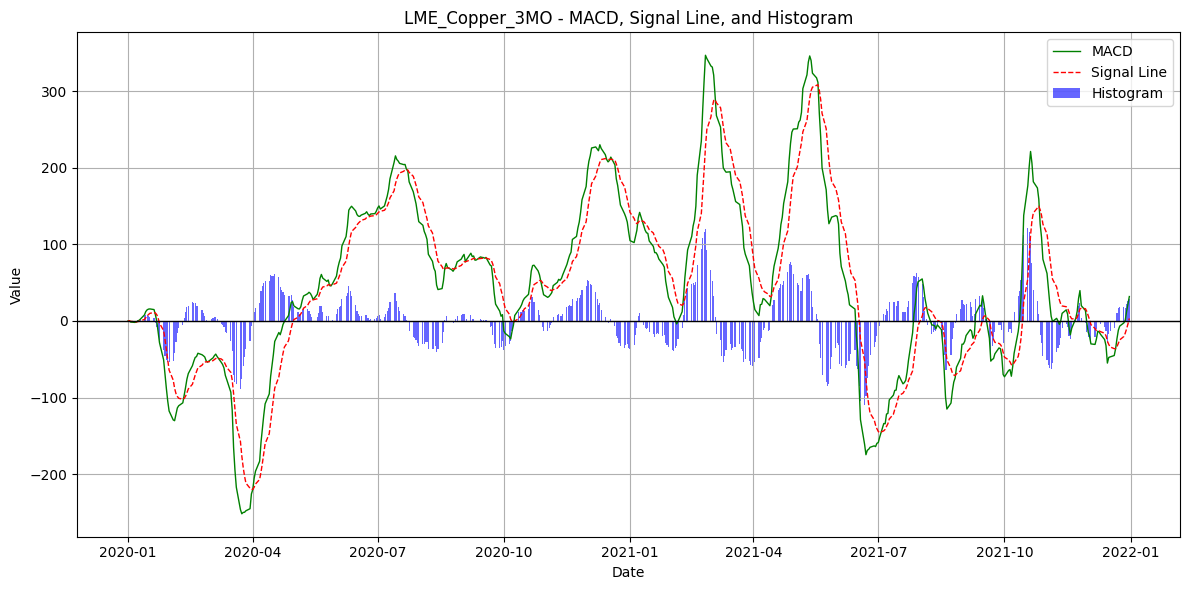

,Date,LME_Copper_3MO,MACD,Signal_Line
2614,2020-01-01,6174.0,0.000000,0.000000
2615,2020-01-02,6188.0,0.314103,0.174501
2616,2020-01-03,6129.5,-1.413852,-0.476463
2617,2020-01-06,6138.5,-1.840169,-0.938423
2618,2020-01-07,6149.0,-1.615263,-1.139768
...,...,...,...,...
3132,2021-12-27,9568.0,-2.500190,-20.259043
3133,2021-12-28,9568.0,0.815513,-16.044131
3134,2021-12-29,9680.5,12.378352,-10.359635
3135,2021-12-30,9691.5,22.173985,-3.852911


In [174]:
apply_macd_strategy(copper_df, 'LME_Copper_3MO')

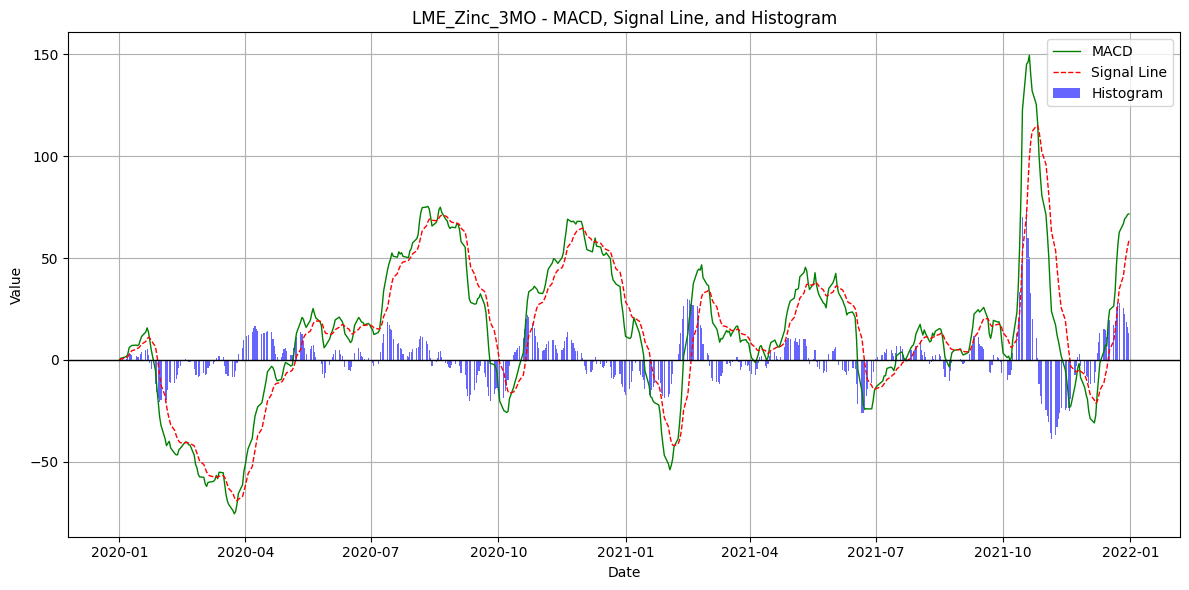

,Date,LME_Zinc_3MO,MACD,Signal_Line
2614,2020-01-01,2272.0,0.000000,0.000000
2615,2020-01-02,2310.0,0.852564,0.473647
2616,2020-01-03,2306.0,0.962296,0.673913
2617,2020-01-06,2324.5,1.656556,1.006787
2618,2020-01-07,2346.0,2.854467,1.556430
...,...,...,...,...
3132,2021-12-27,3519.0,66.849430,41.187284
3133,2021-12-28,3519.0,69.361656,46.822159
3134,2021-12-29,3513.0,70.060845,51.469896
3135,2021-12-30,3532.5,71.365785,55.449074


In [175]:
apply_macd_strategy(zinc_df, 'LME_Zinc_3MO')

In [176]:
def calculate_rsi(df, price_column, period=14, over_bought = 70, over_sold = 30):
    """
    Calculates the Relative Strength Index (RSI) for an asset.
    By default uses the standard period of 14 days
    By default over bought level is 70 and over sold is 30 as standard
    
    Inputs: dataframe, price column which contains last settlment price data
    Outputs: a dataframe with RSI metrics, an RSI plot with overbought and oversold lines to indicate buy and sell
    
    """
    df['Change'] = df[price_column].diff()
    df['Gain'] = np.where(df['Change']>0, df['Change'],0)
    df['Loss'] = np.where(df['Change']<0, -df['Change'],0)
    
    df['Avg Gain'] = df['Gain'].rolling(window = 14).mean()
    df['Avg Loss'] = df['Loss'].rolling(window = 14).mean()
    
    df['RS']= df['Avg Gain']/df['Avg Loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    

    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['RSI'], label='RSI', color='blue')
    plt.axhline(over_bought, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(over_sold, color='green', linestyle='--', label='Oversold (30)')
    plt.title(f'{price_column} - Relative Strength Index (RSI)')
    plt.xlabel('Date')
    plt.ylabel('RSI Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df[['Date', price_column, 'RSI']]

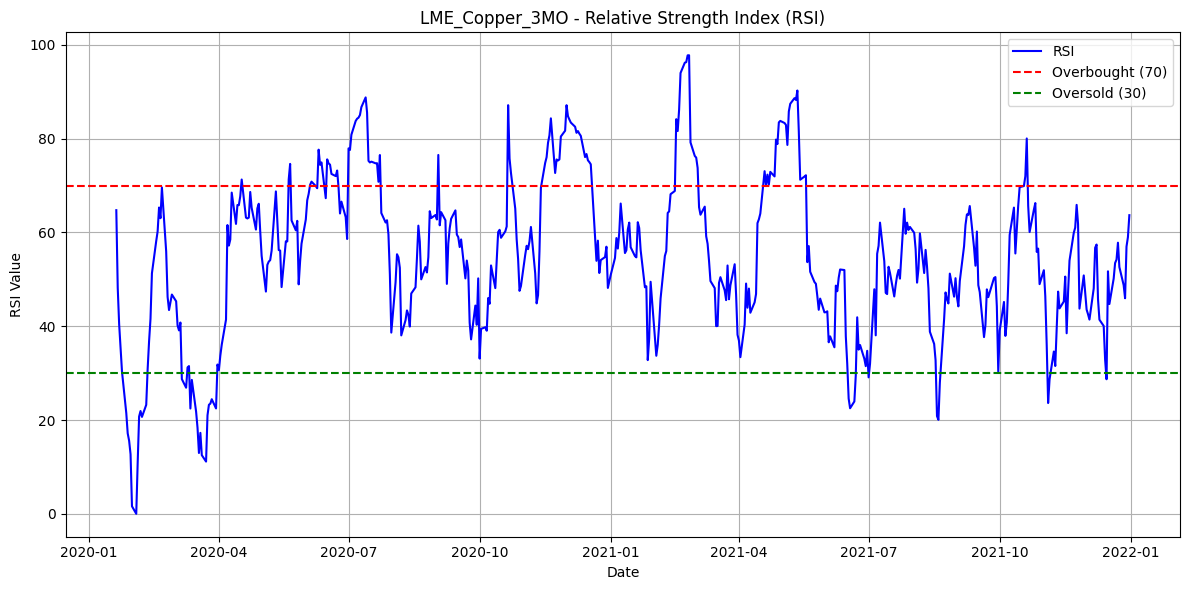

,Date,LME_Copper_3MO,RSI
2614,2020-01-01,6174.0,NaN
2615,2020-01-02,6188.0,NaN
2616,2020-01-03,6129.5,NaN
2617,2020-01-06,6138.5,NaN
2618,2020-01-07,6149.0,NaN
...,...,...,...
3132,2021-12-27,9568.0,48.780488
3133,2021-12-28,9568.0,45.974273
3134,2021-12-29,9680.5,56.992337
3135,2021-12-30,9691.5,59.006816


In [177]:
calculate_rsi(copper_df, 'LME_Copper_3MO')

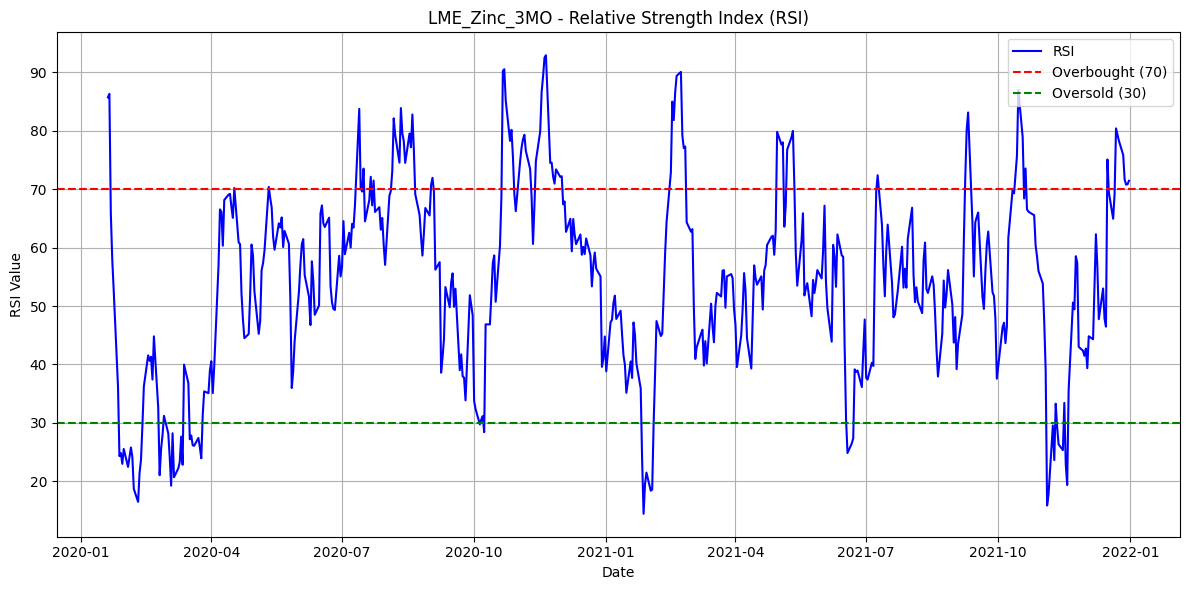

,Date,LME_Zinc_3MO,RSI
2614,2020-01-01,2272.0,NaN
2615,2020-01-02,2310.0,NaN
2616,2020-01-03,2306.0,NaN
2617,2020-01-06,2324.5,NaN
2618,2020-01-07,2346.0,NaN
...,...,...,...
3132,2021-12-27,3519.0,75.816417
3133,2021-12-28,3519.0,71.635611
3134,2021-12-29,3513.0,70.756646
3135,2021-12-30,3532.5,70.816327


In [178]:
calculate_rsi(zinc_df, 'LME_Zinc_3MO')

In [179]:
connection = sqlite3.connect('metal_prices.db')
cursor = connection.cursor()

In [180]:
## checking the tables are all there
cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()

[('LME_Copper_3MO',),
 ('LME_Aluminum_3MO',),
 ('LME_Zinc_3MO',),
 ('LME_Lead_3MO',),
 ('LME_Tin_3MO',),
 ('Generic_CL_Future',)]

In [181]:
## defining the decorator to log sql insert executions
def log_execution(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        print(f"Executing {func.__name__} at {datetime.now()}")
        result = func(*args, **kwargs)
        print(f"Execution completed at {datetime.now()}")
        return result
    return wrapper

In [182]:
## function that adds the desired columns to the desired tables
def alter_metal(connection, tables, cols):
    cursor = connection.cursor()

    for table in tables:
        cursor.execute(f"PRAGMA table_info({table})")
        existing_columns = [row[1] for row in cursor.fetchall()]  
        for col in cols:
            if col not in existing_columns:
                cursor.execute(f"ALTER TABLE {table} ADD COLUMN {col} REAL DEFAULT NULL")
                print(f"Added column {col} to table {table}.")
            else:
                print(f"Column {col} already exists in table {table}.")

    connection.commit()
tables = ['LME_Copper_3MO', 'LME_Zinc_3MO']
cols = ['MACD', 'Signal_Line', 'RSI']    
alter_metal(connection, tables, cols)

Column MACD already exists in table LME_Copper_3MO.
Column Signal_Line already exists in table LME_Copper_3MO.
Column RSI already exists in table LME_Copper_3MO.
Column MACD already exists in table LME_Zinc_3MO.
Column Signal_Line already exists in table LME_Zinc_3MO.
Column RSI already exists in table LME_Zinc_3MO.


In [183]:
## chekcing that the columns have been added correctly
print(cursor.execute("PRAGMA table_info('LME_Copper_3MO')").fetchall())
print(cursor.execute("PRAGMA table_info('LME_Zinc_3MO')").fetchall())

[(0, 'date', 'DATE', 0, None, 1), (1, 'price', 'REAL', 0, None, 0), (2, 'MACD', 'REAL', 0, 'NULL', 0), (3, 'Signal_Line', 'REAL', 0, 'NULL', 0), (4, 'RSI', 'REAL', 0, 'NULL', 0)]
[(0, 'date', 'DATE', 0, None, 1), (1, 'price', 'REAL', 0, None, 0), (2, 'MACD', 'REAL', 0, 'NULL', 0), (3, 'Signal_Line', 'REAL', 0, 'NULL', 0), (4, 'RSI', 'REAL', 0, 'NULL', 0)]


In [184]:
## calling the decorator 
## function that iterates through the df and logs the data into the corresponding table
@log_execution
def update_metal_data(cursor, metal, Date, MACD=None, Signal_Line=None, RSI=None):
    Date = Date.strftime('%Y-%m-%d')

    cursor.execute(f"""
        UPDATE {metal}
        SET MACD = ?, Signal_Line = ?, RSI = ?
        WHERE Date = ?
    """, (MACD, Signal_Line, RSI, Date))

    connection.commit()
    
for index, row in copper_df.iterrows():
    Date = row['Date']
    MACD = row['MACD']
    Signal_Line = row['Signal_Line']
    RSI = row['RSI']
    update_metal_data(cursor, 'LME_Copper_3MO', Date, MACD, Signal_Line, RSI)
    update_metal_data(cursor, 'LME_Zinc_3MO', Date, MACD, Signal_Line, RSI)



Executing update_metal_data at 2024-11-17 19:25:30.434980
Execution completed at 2024-11-17 19:25:30.434980
Executing update_metal_data at 2024-11-17 19:25:30.434980
Execution completed at 2024-11-17 19:25:30.434980
Executing update_metal_data at 2024-11-17 19:25:30.434980
Execution completed at 2024-11-17 19:25:30.434980
Executing update_metal_data at 2024-11-17 19:25:30.434980
Execution completed at 2024-11-17 19:25:30.434980
Executing update_metal_data at 2024-11-17 19:25:30.434980
Execution completed at 2024-11-17 19:25:30.434980
Executing update_metal_data at 2024-11-17 19:25:30.434980
Execution completed at 2024-11-17 19:25:30.434980
Executing update_metal_data at 2024-11-17 19:25:30.434980
Execution completed at 2024-11-17 19:25:30.434980
Executing update_metal_data at 2024-11-17 19:25:30.434980
Execution completed at 2024-11-17 19:25:30.434980
Executing update_metal_data at 2024-11-17 19:25:30.434980
Execution completed at 2024-11-17 19:25:30.434980
Executing update_metal_data 

In [185]:
## checking the data has been logged correctly
cursor.execute("""
    SELECT date, 
           ROUND(MACD, 2) AS MACD,
           ROUND(Signal_Line, 2) AS Signal_Line,
           ROUND(RSI, 2) AS RSI
    FROM 'LME_Zinc_3MO'
    WHERE date BETWEEN '2020-01-01' AND '2021-12-31'
    LIMIT 20
""").fetchall()

[('2020-01-01', 0.0, 0.0, None),
 ('2020-01-02', 0.31, 0.17, None),
 ('2020-01-03', -1.41, -0.48, None),
 ('2020-01-06', -1.84, -0.94, None),
 ('2020-01-07', -1.62, -1.14, None),
 ('2020-01-08', -0.21, -0.89, None),
 ('2020-01-09', 0.79, -0.46, None),
 ('2020-01-10', 2.3, 0.2, None),
 ('2020-01-13', 7.87, 1.97, None),
 ('2020-01-14', 12.33, 4.29, None),
 ('2020-01-15', 14.58, 6.54, None),
 ('2020-01-16', 15.51, 8.47, None),
 ('2020-01-17', 15.74, 10.01, None),
 ('2020-01-20', 14.9, 11.03, 64.76),
 ('2020-01-21', 8.19, 10.44, 48.19),
 ('2020-01-22', -0.27, 8.24, 40.4),
 ('2020-01-23', -14.08, 3.67, 35.38),
 ('2020-01-24', -28.34, -2.85, 30.31),
 ('2020-01-27', -50.69, -12.56, 21.49),
 ('2020-01-28', -69.91, -24.16, 17.15)]

In [186]:
connection.close()